# <h1><b><I> General Setup

## Imports and general setup

In [1]:
from BFCalc.createspectragrids import singlechannel_diffflux, getspectrafunc, darkmatterdoubleinput, energymassinputspectralfunc
from utils3d import log10eaxistrue, longitudeaxistrue, latitudeaxistrue, log10eaxis, longitudeaxis, latitudeaxis, time,psf, edisp, bkgdist, interpolate, special, integrate
from utils3d import SkyCoord, WcsGeom, inverse_transform_sampling, tqdm, setup_full_fake_signal_dist_copy_vers#, setup_full_fake_signal_dist, diff_irf_marg
from marginalisation_class import hyperparameter_likelihood
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from astropy import units as u
from scipy import special,stats
from scipy.integrate import simps
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm
import os, sys
import functools
from multiprocessing import Pool, freeze_support
import multiprocessing
import pandas as pd
sys.path.append("BFCalc")




from prior import discrete_logprior
from likelihood import discrete_loglikelihood


/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
astrophysicalbackground = np.load("unnormalised_astrophysicalbackground.npy")
psfnormalisationvalues = np.load("psfnormalisation.npy")
edispnormalisationvalues = np.load("edispnormalisation.npy")


In [3]:
log10emeshtrue, lonmeshtrue, latmeshtrue = np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')
lonmeshrecon, latmeshrecon = np.meshgrid(longitudeaxis, latitudeaxis, indexing='ij')

logjacobtrue = np.meshgrid(np.log(10**log10eaxistrue), longitudeaxistrue, latitudeaxistrue, indexing='ij')[0]


print(lonmeshtrue.shape, lonmeshrecon.shape)

(341, 35, 30) (18, 15)


## Script Parameter Setup

In [4]:
numberoftruevaluesamples = int(1e4)
Nsamples=numberoftruevaluesamples
truelambda          = 0.8
nsig                = int(round(truelambda*Nsamples))
nbkg                = int(round((1-truelambda)*Nsamples))

truelambda          = nsig/(nbkg+nsig)
numcores            = 8
truelogmass      = 1.0

startertimer = time.perf_counter()
print(startertimer)

6.404550125


# <h1><b>Simulation

## Setup

### Background setup

In [5]:
unnormed_logbkgpriorvalues = np.logaddexp(np.squeeze(bkgdist(log10emeshtrue, lonmeshtrue,latmeshtrue)),np.log(astrophysicalbackground))


logbkgpriorvalues = unnormed_logbkgpriorvalues - special.logsumexp(unnormed_logbkgpriorvalues+logjacobtrue)

logbkgpriorvalues.shape

astrophysicalbackground = np.load("unnormalised_astrophysicalbackground.npy")
from utils3d import bkgdist

nuisancemesh = np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')

unnormed_logbkgpriorvalues = np.logaddexp(np.squeeze(bkgdist(*nuisancemesh)),np.log(astrophysicalbackground))
# unnormed_logbkgpriorvalues = np.squeeze(bkgdist(*nuisancemesh))


logbkgfunc_annoying = interpolate.RegularGridInterpolator((log10eaxistrue, longitudeaxistrue, latitudeaxistrue), np.exp(unnormed_logbkgpriorvalues))
logbkgfunc = lambda logenergy, longitude, latitude: np.log(logbkgfunc_annoying((logenergy, longitude, latitude)))


bkg_prior = discrete_logprior(logfunction=logbkgfunc, name='Background Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), 
                               axes_names=['energy', 'lon', 'lat'], logjacob=logjacobtrue)

### Signal Setup

In [6]:
darkSUSY_to_Gammapy_converter = {
    "tt": "t",
    "W+W-": "W",
    "ZZ": "Z",
    "HH": "h",
}

darkSUSY_BFs_cleaned = pd.read_csv('BFCalc/darkSUSY_BFs/darkSUSY_BFs_cleaned.csv', delimiter=' ')

darkSUSY_massvalues = darkSUSY_BFs_cleaned.iloc[:,1]/1e3

darkSUSY_lambdavalues = darkSUSY_BFs_cleaned.iloc[:,2]

channelfuncdictionary = {}

modulefolderpath = 'BFCalc'
log10xvals = np.load(modulefolderpath+f"/griddata/log10xvals_massenergy_diffflux_grid.npy")
massvalues = np.load(modulefolderpath+f"/griddata/massvals_massenergy_diffflux_grid.npy")

for darkSUSYchannel in list(darkSUSY_to_Gammapy_converter.keys()):
    try:
        gammapychannel = darkSUSY_to_Gammapy_converter[darkSUSYchannel]
        
        tempspectragrid = np.load(modulefolderpath+f"/griddata/channel={gammapychannel}_massenergy_diffflux_grid.npy")
        
        channelfuncdictionary[darkSUSYchannel] = interpolate.RegularGridInterpolator((np.log10(massvalues/1e3), log10xvals), np.array(tempspectragrid), 
                                                                                 method='linear', bounds_error=False, fill_value=1e-3000)
    except:
        channelfuncdictionary[darkSUSYchannel] = lambda logmass, log10x: log10x*0


partial_sigmav_interpolator_dictionary = {channel: interpolate.LinearNDInterpolator((darkSUSY_massvalues, darkSUSY_lambdavalues),darkSUSY_BFs_cleaned.iloc[:,idx+3]) for idx, channel in enumerate(list(darkSUSY_to_Gammapy_converter.keys()))}



def nontrivial_coupling(logmass, logenergy, coupling=0.1, partial_sigmav_interpolator_dictionary=partial_sigmav_interpolator_dictionary, channelfuncdictionary=channelfuncdictionary ):
    
    logspectra = -np.inf
    for channel in channelfuncdictionary.keys():
        logspectra = np.logaddexp(logspectra, np.log(partial_sigmav_interpolator_dictionary[channel](10**logmass, coupling)*channelfuncdictionary[channel]((logmass, logenergy-logmass))))
        
    return logspectra
        
    
    



In [7]:
from SS_DM_Prior import SS_DM_dist_setup


logDMpriorfunc = SS_DM_dist_setup(nontrivial_coupling, longitudeaxistrue, latitudeaxistrue)





In [8]:
DM_prior = discrete_logprior(logfunction=logDMpriorfunc, name='Scalar Singlet Dark Matter Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), axes_names=['energy', 'lon', 'lat'],
                               default_hyperparameter_values=(truelogmass,), hyperparameter_names=['mass'], logjacob=logjacobtrue)
DM_prior

(1.0,)


discrete log prior class
----------------------------
name = Scalar Singlet Dark Matter Prior
logfunction type is <function SS_DM_dist_setup.<locals>.DM_signal_dist at 0x7fc8e86d3d30>
input units of None
over axes ['energy', 'lon', 'lat']
with hyperparameter(s) ['mass']

In [9]:
signalspecfunc = nontrivial_coupling
signalfunc = setup_full_fake_signal_dist_copy_vers(truelogmass, signalspecfunc)
truelogmass

1.0

## True Value Simulation

In [10]:
if truelambda!=0.0:
    siglogevals,siglonvals,siglatvals  = DM_prior.sample(nsig)
else:
    siglogevals = np.asarray([])
    siglonvals = np.asarray([])
    siglatvals = np.asarray([])

In [11]:

if truelambda!=1.0:
    bkglogevals,bkglonvals,bkglatvals  = bkg_prior.sample(nbkg)
else:
    bkglogevals = np.asarray([])
    bkglonvals = np.asarray([])
    bkglatvals = np.asarray([])

## Reconstructed Value Simulation

In [12]:
logjacob = np.meshgrid(np.log(10**log10eaxis), longitudeaxis, latitudeaxis, indexing='ij')[0]

In [13]:
from utils3d import edisp_test, psf_test, log10eaxis, longitudeaxis, latitudeaxis
logjacob = np.log(10**log10eaxis)
edisp_like = discrete_loglikelihood(logfunction=edisp_test, 
                                    axes=(log10eaxis,), axes_names='log10E recon',
                                    name='energy dispersion',
                                    dependent_axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), logjacob=logjacob,
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])

Number of input dimensions 1
boop
Axes shape: (171,)


In [14]:
psf_like = discrete_loglikelihood(logfunction=psf_test, 
                                    axes=(longitudeaxis, latitudeaxis), axes_names=['longitude recon', 'latitude recon'],
                                    name='point spread function ',
                                    dependent_axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,),
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])
psf_like

Number of input dimensions 2
beeeep
Number of data dimensions 2
Axes shape: (18, 15)


discrete log likelihood class
---------------------------------
name = point spread function 
logfunction type is <function psf_test at 0x7fc903df7790>
input units of None
over axes ['longitude recon', 'latitude recon']
with dependent axes ['log10E true', 'lon', 'lat']

### Signal

In [15]:

if truelambda!=0.0:
    # sig_log10e_edisp_samples = [edisp_like.sample(signal_event_tuple, 1).tolist() for signal_event_tuple in tqdm(sig_samples.T)]
    signal_log10e_measured = [np.squeeze(edisp_like.sample((logeval,*coord,), numsamples=1)) for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)]
else:
    signal_log10e_measured = np.asarray([])

 48%|████▊     | 3875/8000 [00:02<00:03, 1341.32it/s]/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/likelihood.py:90: RuntimeWarning: invalid value encountered in subtract
  loglikevalswithlogjacob = loglikevalswithlogjacob - logsumexp(loglikevalswithlogjacob, axis=(*np.arange(self.axes_dim),))
100%|██████████| 8000/8000 [00:05<00:00, 1334.60it/s]


In [16]:

signal_lon_measured = []
signal_lat_measured = []

if truelambda!=0:
    
    sig_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1).tolist() for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)]
    
    for sig_lonlat_psf_sample in sig_lonlat_psf_samples:
        signal_lon_measured.append(sig_lonlat_psf_sample[0])
        signal_lat_measured.append(sig_lonlat_psf_sample[1])

100%|██████████| 8000/8000 [00:54<00:00, 146.53it/s]


### Background

In [17]:
if truelambda!=1.0:
    # sig_log10e_edisp_samples = [edisp_like.sample(signal_event_tuple, 1).tolist() for signal_event_tuple in tqdm(sig_samples.T)]
    bkg_log10e_measured = [np.squeeze(edisp_like.sample((logeval,*coord,), numsamples=1)) for logeval,coord  in notebook_tqdm(zip(bkglogevals, np.array([bkglonvals, bkglatvals]).T), total=nbkg)]
else:
    bkg_log10e_measured = np.asarray([])

100%|██████████| 2000/2000 [00:01<00:00, 1223.33it/s]


In [18]:
bkg_lon_measured = []
bkg_lat_measured = []

if truelambda!=0:
    
    bkg_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1).tolist() for logeval,coord  in notebook_tqdm(zip(bkglogevals, np.array([bkglonvals, bkglatvals]).T), total=nbkg)]
    
    for bkg_lonlat_psf_sample in bkg_lonlat_psf_samples:
        bkg_lon_measured.append(bkg_lonlat_psf_sample[0])
        bkg_lat_measured.append(bkg_lonlat_psf_sample[1])


100%|██████████| 2000/2000 [00:14<00:00, 141.83it/s]


## Final simulation output

In [19]:


try:
    measured_log10e = list(signal_log10e_measured)+list(bkg_log10e_measured)
    measured_lon = list(signal_lon_measured)+list(bkg_lon_measured)
    measured_lat = list(signal_lat_measured)+list(bkg_lat_measured)
    
except:
    if type(bkg_log10e_measured)==np.float64:
        measured_log10e = list(signal_log10e_measured)
        measured_lon = list(signal_lon_measured)
        measured_lat = list(signal_lat_measured)
        measured_log10e.append(bkg_log10e_measured)
        measured_lon.append(bkg_lon_measured)
        measured_lat.append(bkg_lat_measured)
        
    elif type(signal_log10e_measured)==np.float64:
        measured_log10e = list(bkg_log10e_measured)
        measured_lon = list(bkg_lon_measured)
        measured_lat = list(bkg_lat_measured)
        measured_log10e.append(signal_log10e_measured)
        measured_lon.append(signal_lon_measured)
        measured_lat.append(signal_lat_measured)
    else:
        print('what')

# <h1><b>Analysis

## Marginalisation

In [20]:
nbinslogmass=31

if nsig is None:
    nsig = len(list(measured_log10e))

logmasswindowwidth      = 7/np.sqrt(nsig)

logmasslowerbound       = truelogmass-logmasswindowwidth
logmassupperbound       = truelogmass+logmasswindowwidth


if logmasslowerbound<log10eaxis[0]:
    logmasslowerbound = log10eaxis[0]
if logmassupperbound>2:
    logmassupperbound = 2


logmassrange            = np.linspace(logmasslowerbound, logmassupperbound, nbinslogmass) 

In [21]:
from utils3d import psf_efficient, edisp_efficient, edisp_test, psf_test, single_likelihood


hyperparameter_likelihood_instance = hyperparameter_likelihood(priors=(DM_prior, bkg_prior,), likelihood=single_likelihood, 
                                                               dependent_axes=(log10eaxistrue,  longitudeaxistrue, latitudeaxistrue), dependent_logjacob=logjacobtrue,
                                                               hyperparameter_axes = (logmassrange, (None,)), numcores=8, likelihoodnormalisation = (psfnormalisationvalues, edispnormalisationvalues))

measured_log10e = [float(measured_log10e_val) for measured_log10e_val in measured_log10e]
margresults = hyperparameter_likelihood_instance.full_obs_marginalisation(axisvals= (measured_log10e, measured_lon, measured_lat))



Setting up prior matrices: 100%|██████████| 2/2 [00:09<00:00,  4.78s/it]
Performing parallelized direct event marginalisation: 100%|██████████| 10000/10000 [00:00<00:00, 2638590.84it/s]
/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/utils3d.py:158: RuntimeWarning: divide by zero encountered in log
  output = np.log(psffull.evaluate(energy_true=10**logetrue*u.TeV,
/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/utils3d.py:162: RuntimeWarning: divide by zero encountered in log
  output+=np.log(edispfull.evaluate(energy_true=10**logetrue*u.TeV,
/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/marginalisation_class.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([np.squeeze(np.array(sigmargresults)), bkgmargresult])


In [22]:
margresultsarray = np.array(margresults)
sigmargresults = np.squeeze(np.vstack(margresultsarray[:,0])).T
bkgmargresults = np.squeeze(np.vstack(margresultsarray[:,1]))
sigmargresults.shape

(31, 10000)

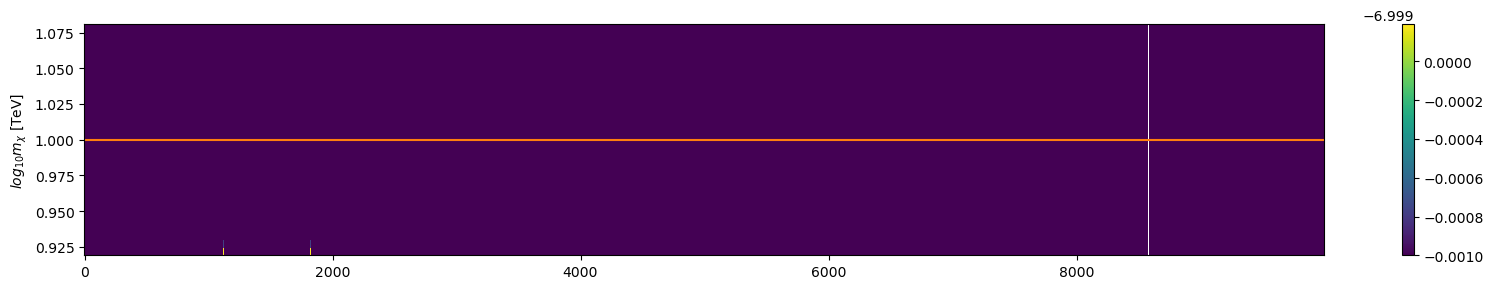

In [23]:
fig, ax = plt.subplots(figsize=(20,3))
plt.pcolormesh(*np.meshgrid(list(range(Nsamples)), logmassrange, indexing='ij'), 
               sigmargresults.T-special.logsumexp(sigmargresults, axis=1), 
               cmap='viridis', vmin=-7)
plt.ylabel(r'$log_{10}m_\chi$ [TeV]')
plt.axhline(truelogmass, c='tab:orange')
plt.colorbar()
plt.show()

## Calculating posterior

In [24]:

nbinslambda            = 81
lambdawindowwidth      = 9/np.sqrt(Nsamples)


lambdalowerbound       = truelambda-lambdawindowwidth
lambdaupperbound       = truelambda+lambdawindowwidth



if lambdalowerbound<0:
    lambdalowerbound = 0
if lambdaupperbound>1:
    lambdaupperbound = 1


lambdarange            = np.linspace(lambdalowerbound, lambdaupperbound, nbinslambda) 

log_posterior = []

for lambdaval in notebook_tqdm(lambdarange, total=lambdarange.shape[0]):
    log_posterior.append([np.sum(np.logaddexp(np.log(lambdaval)+sigmargresults[logmassindex,:], np.log(1-lambdaval)+bkgmargresults)) for logmassindex in range(len(list(logmassrange)))])

log_posterior = np.array(log_posterior)-special.logsumexp(log_posterior)


endertimer = time.perf_counter()
print(endertimer-startertimer)

100%|██████████| 81/81 [00:00<00:00, 123.53it/s]

805.574115667


# <h1><b>Plotting

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_47306/4235438127.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues_r', 4)


0.0016364786891371384
0.0011384199576606176
0.0005692099788303088
0.0004980587314765175
0.0010672687103068263
0.0015653274417833474


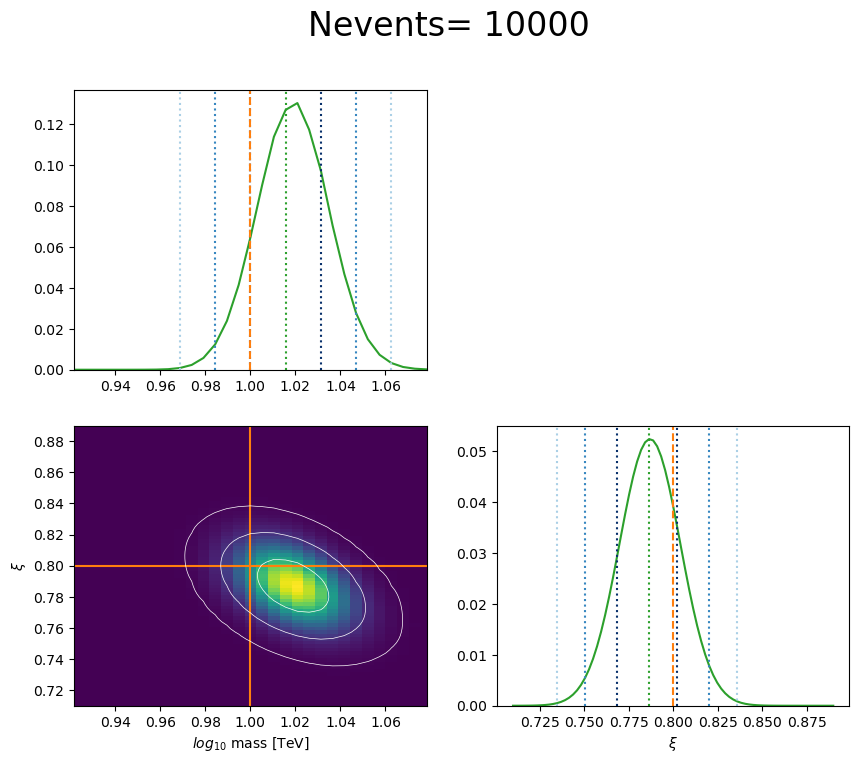

In [25]:
from utils3d import confidence_ellipse
from scipy.stats import norm

import time

colormap = cm.get_cmap('Blues_r', 4)

fig, ax = plt.subplots(2,2, dpi=100, figsize=(10,8))
plt.suptitle(f"Nevents= {Nsamples}", size=24)

# Upper left plot
logmass_logposterior = special.logsumexp(log_posterior, axis=0)

normalisedlogmassposterior = np.exp(logmass_logposterior-special.logsumexp(logmass_logposterior))

cdflogmassposterior = np.cumsum(normalisedlogmassposterior)
mean = logmassrange[np.abs(norm.cdf(0)-cdflogmassposterior).argmin()]
zscores = [-3, -2,-1,1,2, 3]
logmasspercentiles = []
for zscore in zscores:
    logmasspercentiles.append(logmassrange[np.abs(norm.cdf(zscore)-cdflogmassposterior).argmin()])


ax[0,0].plot(logmassrange,normalisedlogmassposterior, c='tab:green')

ax[0,0].axvline(mean, c='tab:green', ls=':')


for o, percentile in enumerate(logmasspercentiles):
            color = colormap(np.abs(zscores[o])/4-0.01)

            ax[0,0].axvline(percentile, c=color, ls=':')
ax[0,0].axvline(truelogmass, ls='--', color="tab:orange")


if min(mean - logmasspercentiles)>log10eaxistrue[1]-log10eaxistrue[0]:
    for logetrueval in log10eaxistrue:
        ax[0,0].axvline(logetrueval, c='forestgreen', alpha=0.3)
ax[0,0].set_ylim([0, None])
ax[0,0].set_xlim([logmassrange[0], logmassrange[-1]])

# Upper right plot
ax[0,1].axis('off')


# Lower left plot
# ax[1,0].pcolormesh(logmassrange, lambdarange, np.exp(normalisedlogposterior).T, cmap='Blues')
ax[1,0].pcolormesh(logmassrange, lambdarange, np.exp(log_posterior), vmin=0)
ax[1,0].axvline(truelogmass, c='tab:orange')
ax[1,0].axhline(truelambda, c='tab:orange')
ax[1,0].set_xlabel(r'$log_{10}$ mass [TeV]')
ax[1,0].set_ylabel(r'$\xi$')

ax[1,0].set_ylim([lambdarange[0], lambdarange[-1]])
ax[1,0].set_xlim([logmassrange[0], logmassrange[-1]])

########################################################################################################################
########################################################################################################################
# I have no clue how this works but I've checked it against some standard distributions and it seems correct
normed_posterior = np.exp(log_posterior)/np.exp(log_posterior).sum()
n = 100000
t = np.linspace(0, normed_posterior.max(), n)
integral = ((normed_posterior >= t[:, None, None]) * normed_posterior).sum(axis=(1,2))

from scipy import interpolate
f = interpolate.interp1d(integral, t)
t_contours = f(np.array([1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)]))
ax[1,0].contour(normed_posterior, t_contours, extent=[logmassrange[0],logmassrange[-1], lambdarange[0],lambdarange[-1]], colors='white', linewidths=0.5)
########################################################################################################################
########################################################################################################################


lambda_logposterior = special.logsumexp(log_posterior, axis=1)

normalisedlambdaposterior = np.exp(lambda_logposterior-special.logsumexp(lambda_logposterior))

cdflambdaposterior = np.cumsum(normalisedlambdaposterior)
meanlambda = lambdarange[np.abs(norm.cdf(0)-cdflambdaposterior).argmin()]
lambdapercentiles = []
for zscore in zscores:
    lambdapercentile = lambdarange[np.abs(norm.cdf(zscore)-cdflambdaposterior).argmin()]
    lambdapercentiles.append(lambdapercentile)
    print(np.sqrt(1e5/1e8)*np.abs(lambdapercentile - meanlambda))





ax[1,1].plot(lambdarange,normalisedlambdaposterior, c='tab:green')

ax[1,1].axvline(meanlambda, c='tab:green', ls=':')


for o, percentile in enumerate(lambdapercentiles):
            color = colormap(np.abs(zscores[o])/4-0.01)

            ax[1,1].axvline(percentile, c=color, ls=':')
ax[1,1].axvline(truelambda, ls='--', color="tab:orange")
ax[1,1].set_xlabel(r'$\xi$')
ax[1,1].set_ylim([0, None])


# plt.savefig(time.strftime(f"Figures/TestFigures/{Nsamples}events_lm{truelogmass}_l{truelambda}_%m%d_%H%M.pdf"))
plt.show()

In [26]:
os.system('say Your code is finished.')

In [27]:
# from utils3d import setup_full_fake_signal_dist, diff_irf_marg


# if __name__=="__main__":
#     nuisance_loge_setup_mesh, nuisance_longitude_setup_mesh, nuisance_latitude_setup_mesh = np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')

#     originalmethod_signal_prior_matrices = []
#     for logmass in logmassrange:
#         originalmethod_priorvals= setup_full_fake_signal_dist(logmass, specfunc=signalspecfunc)(nuisance_loge_setup_mesh, nuisance_longitude_setup_mesh, nuisance_latitude_setup_mesh)
        
#         originalmethod_priorvals = originalmethod_priorvals - special.logsumexp(logjacobtrue+originalmethod_priorvals)
#         originalmethod_signal_prior_matrices.append(originalmethod_priorvals.T)
    
    
#     originalmethod_marg_partial = functools.partial(diff_irf_marg, signal_prior_matrices=originalmethod_signal_prior_matrices, logbkgpriorvalues=logbkgpriorvalues, 
#                                                     logmassrange=logmassrange, edispnormvalues=edispnormalisationvalues, psfnormvalues=psfnormalisationvalues)

#     with Pool(numcores) as pool:
#             originalmethod_margresults = pool.map(originalmethod_marg_partial, tqdm(zip(measured_log10e, measured_lon, measured_lat), total=len(list(measured_log10e))))

 25%|██▌       | 2504/10000 [00:01<00:03, 1908.39it/s]/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/utils3d.py:506: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([np.squeeze(np.array(sigmargresults)), bkgmargresult])
/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/utils3d.py:506: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([np.squeeze(np.array(sigmargresults)), bkgmargresult])
/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/utils3d.py:506: VisibleDeprecationWarning: Creating an ndarray from ragged nested s

In [ ]:
originalmethod_margresultsarray = np.array(originalmethod_margresults)
originalmethod_sigmargresults = np.squeeze(np.vstack(originalmethod_margresultsarray[:,0])).T
originalmethod_bkgmargresults = np.squeeze(np.vstack(originalmethod_margresultsarray[:,1]))
originalmethod_sigmargresults.shape

(31, 1000)

In [ ]:

nbinslambda            = 81
lambdawindowwidth      = 9/np.sqrt(Nsamples)


lambdalowerbound       = truelambda-lambdawindowwidth
lambdaupperbound       = truelambda+lambdawindowwidth



if lambdalowerbound<0:
    lambdalowerbound = 0
if lambdaupperbound>1:
    lambdaupperbound = 1


lambdarange            = np.linspace(lambdalowerbound, lambdaupperbound, nbinslambda) 

originalmethod_log_posterior = []

for lambdaval in notebook_tqdm(lambdarange, total=lambdarange.shape[0]):
    originalmethod_log_posterior.append([np.sum(np.logaddexp(np.log(lambdaval)+sigmargresults[logmassindex,:], np.log(1-lambdaval)+bkgmargresults)) for logmassindex in range(len(list(logmassrange)))])

originalmethod_log_posterior = np.array(originalmethod_log_posterior)-special.logsumexp(originalmethod_log_posterior)


endertimer = time.perf_counter()
print(endertimer-startertimer)

100%|██████████| 81/81 [00:00<00:00, 925.49it/s]

232.51998933299998


/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_39657/3766419917.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues_r', 4)


0.005363594362117862
0.003448024947075767
0.0017240124735378834
0.0017240124735378869
0.0032564680055715617
0.0042142527130926075


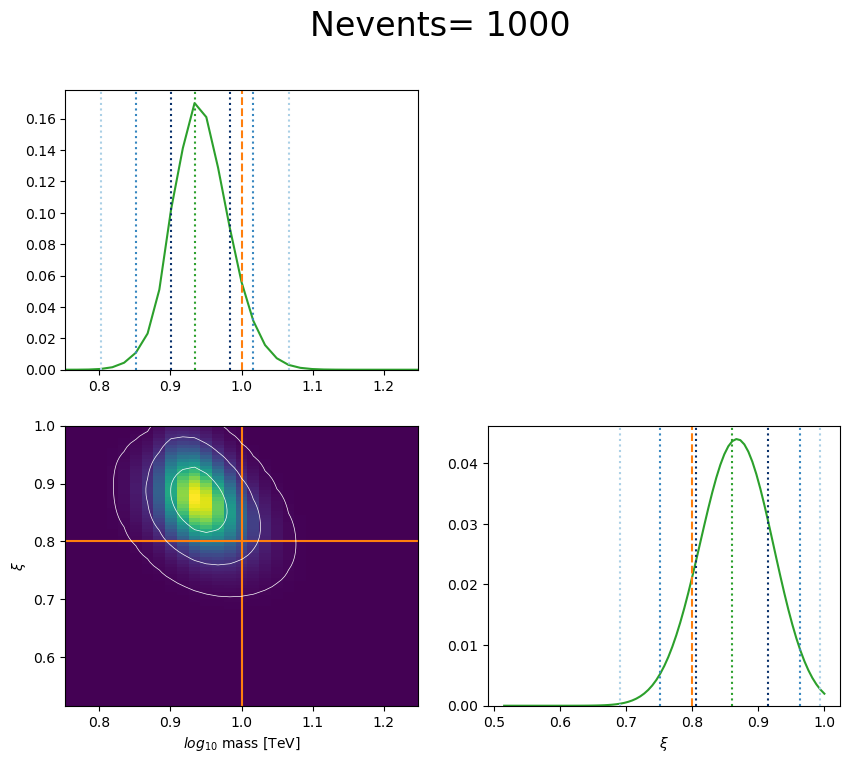

In [ ]:
from utils3d import confidence_ellipse
from scipy.stats import norm

import time

colormap = cm.get_cmap('Blues_r', 4)

fig, ax = plt.subplots(2,2, dpi=100, figsize=(10,8))
plt.suptitle(f"Nevents= {Nsamples}", size=24)

# Upper left plot
originalmethod_logmass_logposterior = special.logsumexp(originalmethod_log_posterior, axis=0)

originalmethod_normalisedlogmassposterior = np.exp(originalmethod_logmass_logposterior-special.logsumexp(originalmethod_logmass_logposterior))

originalmethod_cdflogmassposterior = np.cumsum(originalmethod_normalisedlogmassposterior)
originalmethod_mean = logmassrange[np.abs(norm.cdf(0)-originalmethod_cdflogmassposterior).argmin()]
originalmethod_zscores = [-3, -2,-1,1,2, 3]
originalmethod_logmasspercentiles = []
for zscore in originalmethod_zscores:
    originalmethod_logmasspercentiles.append(logmassrange[np.abs(norm.cdf(zscore)-originalmethod_cdflogmassposterior).argmin()])


ax[0,0].plot(logmassrange,originalmethod_normalisedlogmassposterior, c='tab:green')

ax[0,0].axvline(originalmethod_mean, c='tab:green', ls=':')


for o, percentile in enumerate(originalmethod_logmasspercentiles):
            color = colormap(np.abs(originalmethod_zscores[o])/4-0.01)

            ax[0,0].axvline(percentile, c=color, ls=':')
ax[0,0].axvline(truelogmass, ls='--', color="tab:orange")



ax[0,0].set_ylim([0, None])
ax[0,0].set_xlim([logmassrange[0], logmassrange[-1]])

# Upper right plot
ax[0,1].axis('off')


# Lower left plot
# ax[1,0].pcolormesh(logmassrange, lambdarange, np.exp(normalisedlogposterior).T, cmap='Blues')
ax[1,0].pcolormesh(logmassrange, lambdarange, np.exp(originalmethod_log_posterior), vmin=0)
ax[1,0].axvline(truelogmass, c='tab:orange')
ax[1,0].axhline(truelambda, c='tab:orange')
ax[1,0].set_xlabel(r'$log_{10}$ mass [TeV]')
ax[1,0].set_ylabel(r'$\xi$')

ax[1,0].set_ylim([lambdarange[0], lambdarange[-1]])
ax[1,0].set_xlim([logmassrange[0], logmassrange[-1]])

########################################################################################################################
########################################################################################################################
# I have no clue how this works but I've checked it against some standard distributions and it seems correct
originalmethod_normed_posterior = np.exp(originalmethod_log_posterior)/np.exp(originalmethod_log_posterior).sum()
n = 100000
originalmethod_t = np.linspace(0, originalmethod_normed_posterior.max(), n)
originalmethod_integral = ((originalmethod_normed_posterior >= originalmethod_t[:, None, None]) * originalmethod_normed_posterior).sum(axis=(1,2))

from scipy import interpolate
originalmethod_f = interpolate.interp1d(originalmethod_integral, originalmethod_t)
originalmethod_t_contours = originalmethod_f(np.array([1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)]))
ax[1,0].contour(originalmethod_normed_posterior, originalmethod_t_contours, extent=[logmassrange[0],logmassrange[-1], lambdarange[0],lambdarange[-1]], colors='white', linewidths=0.5)
########################################################################################################################
########################################################################################################################


originalmethod_lambda_logposterior = special.logsumexp(originalmethod_log_posterior, axis=1)

originalmethod_normalisedlambdaposterior = np.exp(originalmethod_lambda_logposterior-special.logsumexp(originalmethod_lambda_logposterior))

originalmethod_cdflambdaposterior = np.cumsum(originalmethod_normalisedlambdaposterior)
originalmethod_meanlambda = lambdarange[np.abs(norm.cdf(0)-originalmethod_cdflambdaposterior).argmin()]
originalmethod_lambdapercentiles = []
for zscore in originalmethod_zscores:
    originalmethod_lambdapercentile = lambdarange[np.abs(norm.cdf(zscore)-originalmethod_cdflambdaposterior).argmin()]
    originalmethod_lambdapercentiles.append(originalmethod_lambdapercentile)
    print(np.sqrt(1e5/1e8)*np.abs(originalmethod_lambdapercentile - originalmethod_meanlambda))





ax[1,1].plot(lambdarange,originalmethod_normalisedlambdaposterior, c='tab:green')

ax[1,1].axvline(originalmethod_meanlambda, c='tab:green', ls=':')


for o, percentile in enumerate(originalmethod_lambdapercentiles):
            color = colormap(np.abs(originalmethod_zscores[o])/4-0.01)

            ax[1,1].axvline(percentile, c=color, ls=':')
ax[1,1].axvline(truelambda, ls='--', color="tab:orange")
ax[1,1].set_xlabel(r'$\xi$')
ax[1,1].set_ylim([0, None])


# plt.savefig(time.strftime(f"Figures/TestFigures/{Nsamples}events_lm{truelogmass}_l{truelambda}_%m%d_%H%M.pdf"))
plt.show()